In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error,r2_score

In [4]:

train = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
stores = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
submission = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv")   
transactions = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")#.sort_values(["store_nbr", "date"])
holidays = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
oil = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")

Joining all relevant datasets

In [5]:
df=pd.merge(train,holidays,on='date',how='left')
df=pd.merge(df,oil,on='date',how='left')
df=pd.merge(df,stores,on='store_nbr',how='left')
display(df.head())

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,family,sales,onpromotion,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


In [6]:
# Changing the data formats of train file
df['date'] = pd.to_datetime(df['date'])
df['onpromotion'] = df['onpromotion'].astype('float16')
df['sales'] = df['sales'].astype('float32')

In [7]:

df['year']=df['date'].dt.year
df['year'].value_counts()

year
2016    670032
2014    659340
2013    657558
2015    655776
2017    411642
Name: count, dtype: int64

In [8]:
grouped_data=df.groupby('date')
time_series = grouped_data[["sales", "dcoilwtico"]].mean().reset_index()
time_series_copy = time_series.set_index("date")

In [11]:
time_series_copy

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,sales,dcoilwtico
date,,
2013-01-01,1.409438,NaN
2013-01-02,278.390808,93.14
2013-01-03,202.840195,92.97
2013-01-04,198.911163,93.12
2013-01-05,267.873260,NaN
...,...,...
2017-08-11,463.733856,48.81
2017-08-12,444.798309,NaN
2017-08-13,485.768616,NaN


<ipython-input-12-570556737117>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sales_data=sales_data.fillna(method='ffill')


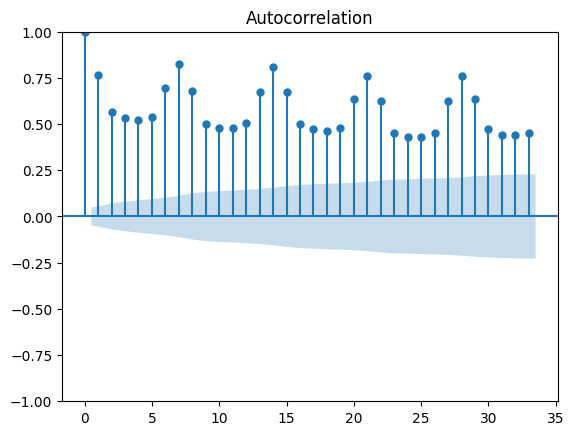

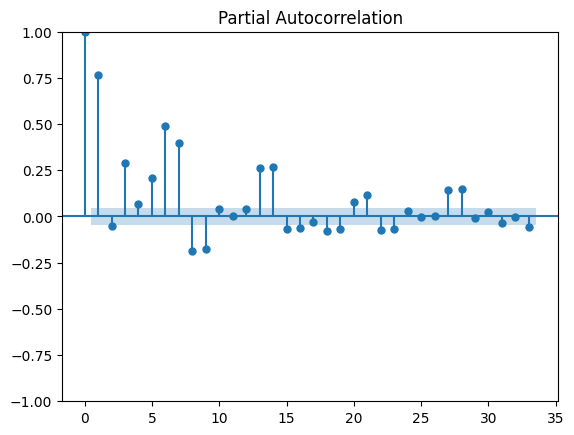

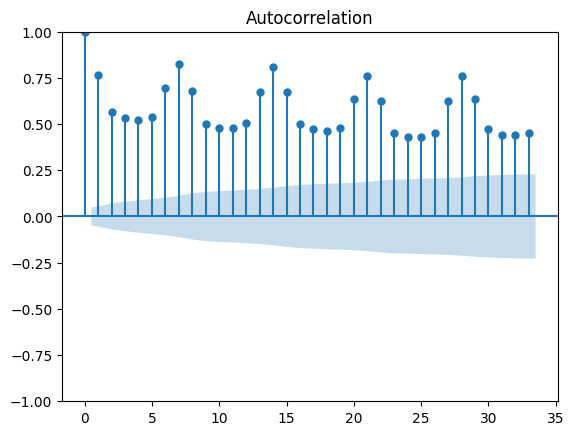

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
sales_data = time_series_copy["sales"].asfreq("D")
sales_data=sales_data.fillna(method='ffill')
plot_pacf(sales_data, alpha=0.05,use_vlines=True, title="Partial Autocorrelation")
plot_acf(sales_data, title="Autocorrelation")

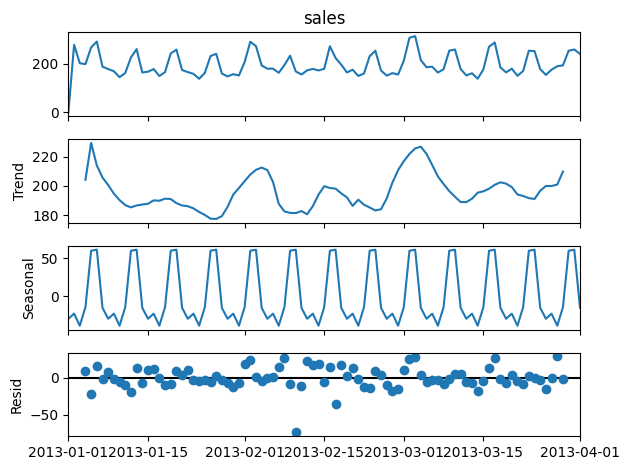

In [14]:
decomposition = sm.tsa.seasonal_decompose(sales_data['2013-01-01':'2013-04-01'], model = "additive")
fig = decomposition.plot()
plt.show()

In [15]:
sales_data

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
                 ...    
2017-08-11    463.733856
2017-08-12    444.798309
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 1688, dtype: float32

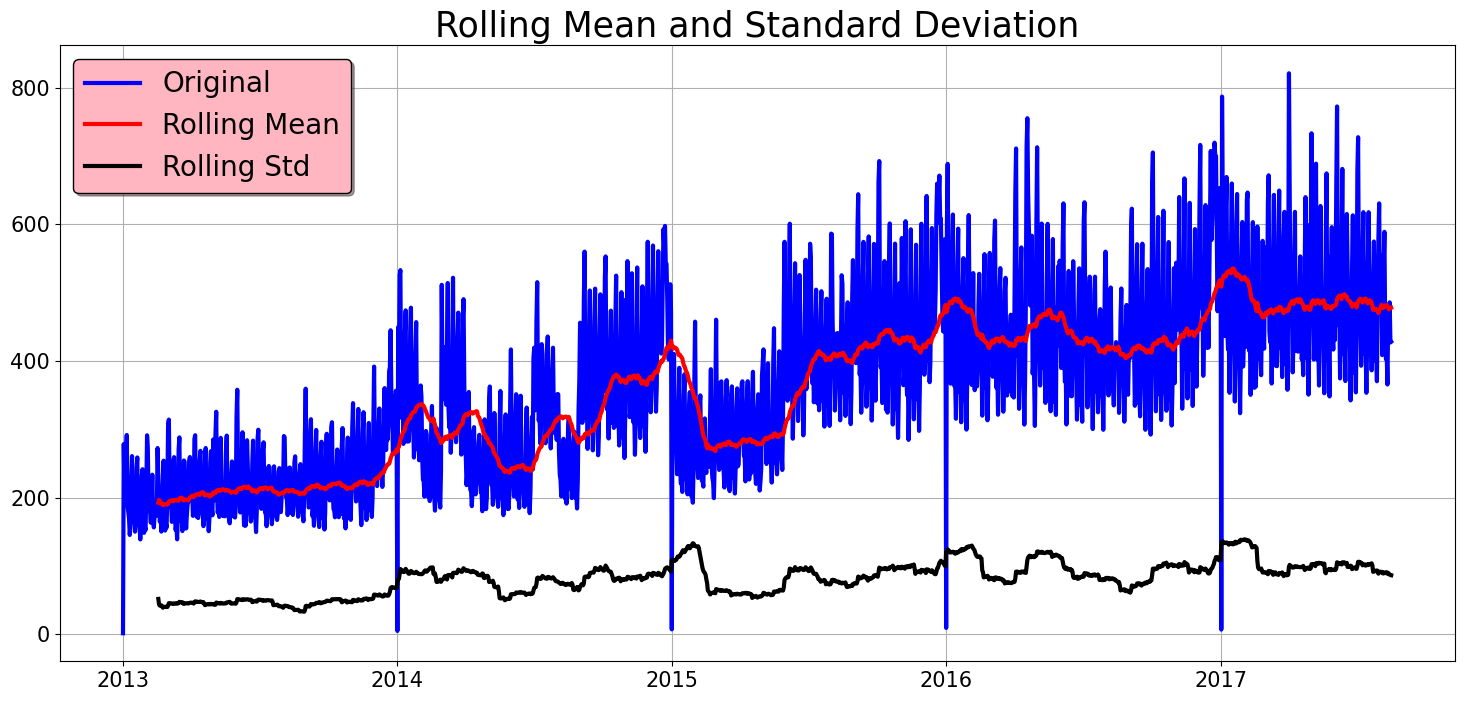

Results of Dickey-Fuller Test
Test Statistics                  -2.623339
p-value                           0.088269
No. of lags used                 22.000000
Number of observations used    1665.000000
critical value (1%)              -3.434284
critical value (5%)              -2.863277
critical value (10%)             -2.567695
dtype: float64


In [16]:

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(48).mean() # rolling mean
    rolstd = timeseries.rolling(48).std() # rolling standard deviation
    
    # Plot rolling statistics
    plt.figure(figsize=(18, 8))  # Reverted back to plt
    plt.grid('both')
    plt.plot(timeseries, color='blue', label='Original', linewidth=3)
    plt.plot(rolmean, color='red', label='Rolling Mean', linewidth=3)
    plt.plot(rolstd, color='black', label='Rolling Std', linewidth=3)
    plt.legend(loc='best', fontsize=20, shadow=True, facecolor='lightpink', edgecolor='k')
    plt.title('Rolling Mean and Standard Deviation', fontsize=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show(block=False)
    
    print("Results of Dickey-Fuller Test")
    adft = adfuller(timeseries, autolag='AIC')
    # we manually write what values does it explain using a for loop
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in adft[4].items():
        output['critical value (%s)' % key] = values
    print(output)

test_stationarity(sales_data)


As seen from the plot, the series has no constant mean and variance, which reflects the series as a non-stationary series. Along with that, the p-value is 0.08 (which is >0.05) making restriction on alternative hypothesis. Thus we choose the null hypothesis. 

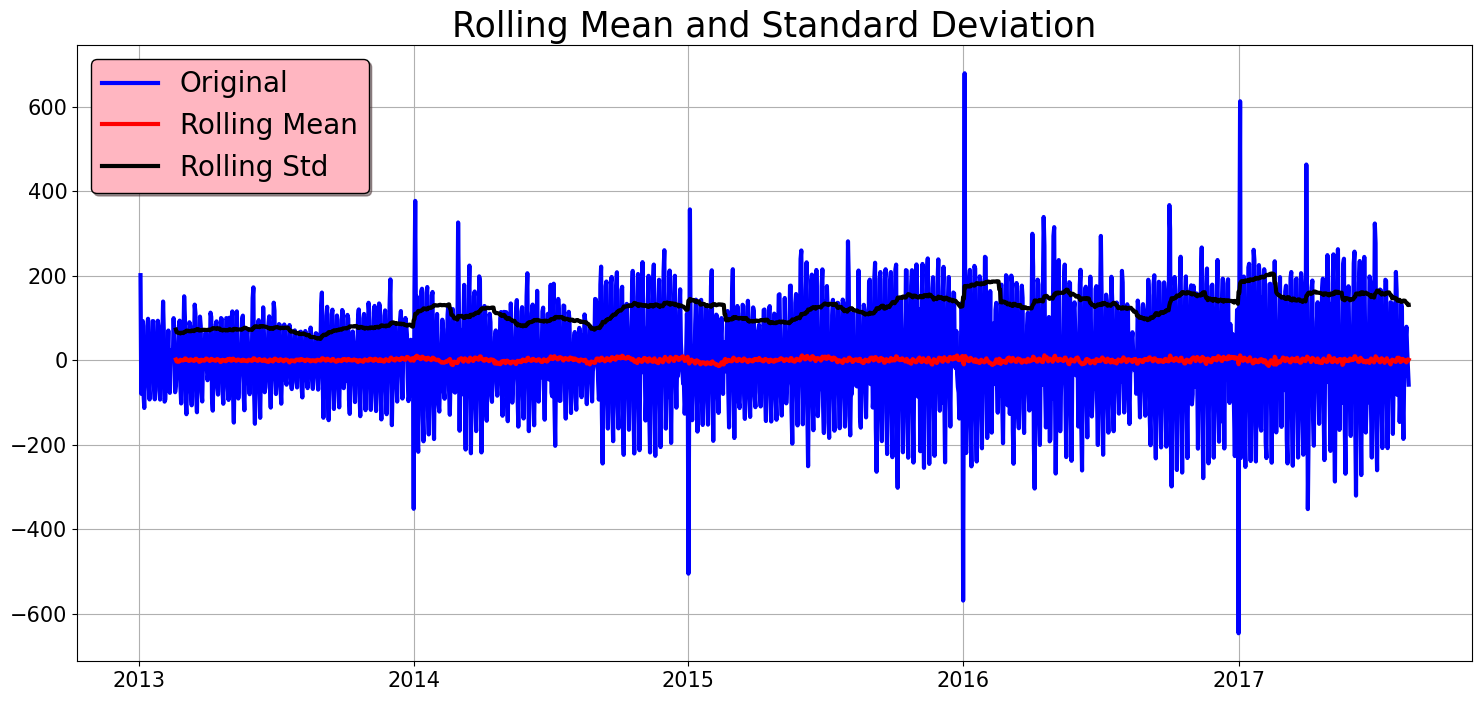

Results of Dickey-Fuller Test
Test Statistics               -1.305268e+01
p-value                        2.126003e-24
No. of lags used               2.500000e+01
Number of observations used    1.660000e+03
critical value (1%)           -3.434295e+00
critical value (5%)           -2.863283e+00
critical value (10%)          -2.567698e+00
dtype: float64


In [17]:
# Making the series into stationary by taking the differencing
sales_data2 = sales_data.diff(2).dropna()
test_stationarity(sales_data2)

Here, p-value is 2.12e-24(which is <0.05), making to choose the alternative hypothesis by deselecting the null hypothesis. This series is said to a stationary series. We would use this series for our future experiments.

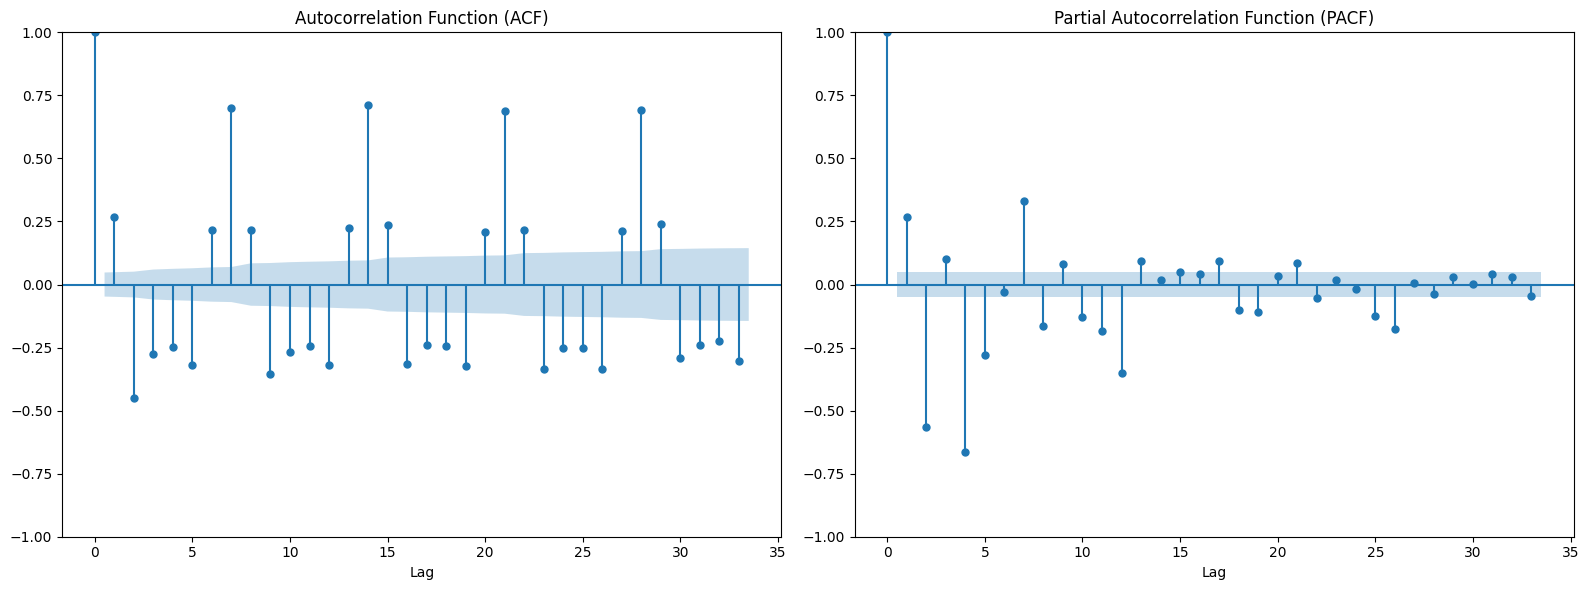

In [18]:
def plot_pacf_acf(series):
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16, 6))
    plot_acf(series, ax=ax[0])  # Use ax[0] for ACF plot
    ax[0].set(xlabel='Lag', title='Autocorrelation Function (ACF)')

    plot_pacf(series, ax=ax[1],method='ywm')  # Use ax[1] for PACF plot
    ax[1].set(xlabel='Lag', title='Partial Autocorrelation Function (PACF)')
    plt.tight_layout()
    plt.show()
    
plot_pacf_acf(sales_data2)

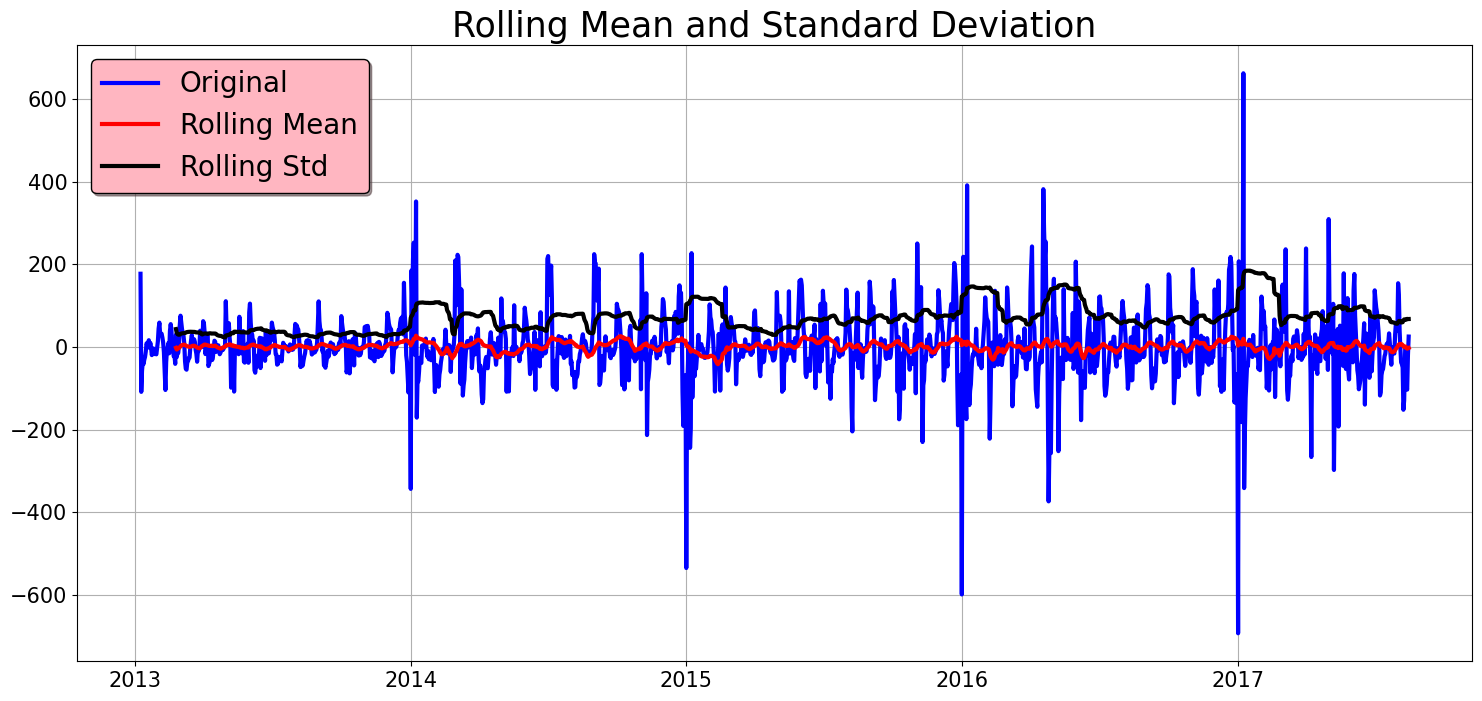

Results of Dickey-Fuller Test
Test Statistics               -1.110135e+01
p-value                        3.858221e-20
No. of lags used               2.300000e+01
Number of observations used    1.657000e+03
critical value (1%)           -3.434303e+00
critical value (5%)           -2.863286e+00
critical value (10%)          -2.567699e+00
dtype: float64


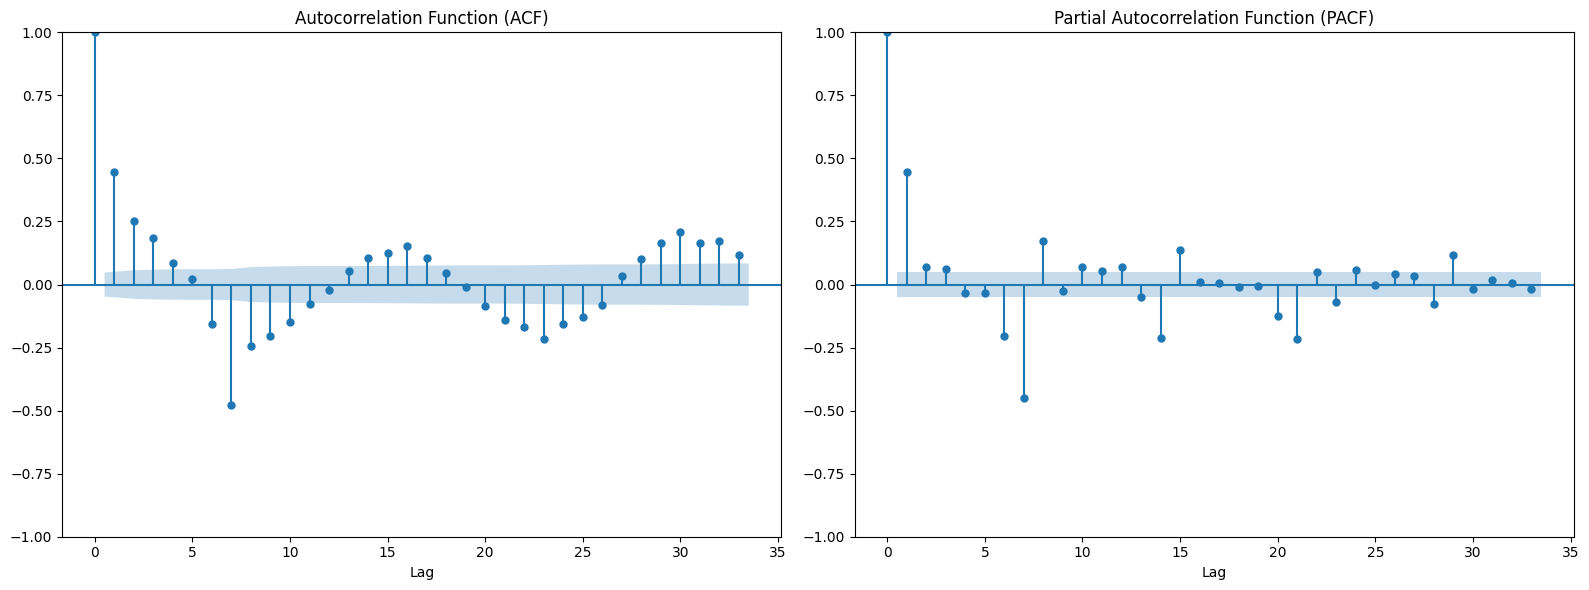

In [19]:
# Finding ACF and PACF by taking differencing order 7
sales_data7=sales_data.diff(7).dropna()
test_stationarity(sales_data7)
plot_pacf_acf(sales_data7)

In [21]:
# Splitting the train data into train (before 2016-01-01) and validation part (from 2016-01-01 to 2017-08-15)
from datetime import datetime,timedelta
train_data=sales_data[:datetime(2016,1,1)]
valid_data=sales_data[datetime(2016,1,1)+timedelta(days=1):]
train_data

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
                 ...    
2015-12-28    443.145294
2015-12-29    488.643097
2015-12-30    578.026794
2015-12-31    541.325256
2016-01-01      9.221883
Freq: D, Name: sales, Length: 1096, dtype: float32

In [22]:
# Fiting the ARIMA model
model=sm.tsa.ARIMA(sales_data,order=(0,2,6),seasonal_order=(3,2,0,7))
model_fit=model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            sales   No. Observations:                 1688
Model:             ARIMA(0, 2, 6)x(3, 2, [], 7)   Log Likelihood               -9531.647
Date:                          Thu, 20 Mar 2025   AIC                          19083.294
Time:                                  08:50:54   BIC                          19137.512
Sample:                              01-01-2013   HQIC                         19103.383
                                   - 08-15-2017                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.6067      0.027    -59.325      0.000      -1.660      -1.554
ma.L2          0.4016      0.032     12.543      0.000       0.339       0.464
ma.L3          0.1872      0.042      4.497      0.000       0.106       0.269
ma.L4         -0.0737      0.037     -1.974      0.048      -0.147      -0.001
ma.L5          0.0146      0.032      0.451      0.652      -0.049       0.078
ma.L6          0.0770      0.016      4.818      0.000       0.046       0.108
ar.S.L7       -1.1708      0.010   -112.046      0.000      -1.191      -1.150
ar.S.L14      -0.8430      0.021    -40.713      0.000      -0.884      -0.802
ar.S.L21      -0.3936      0.015    -26.688      0.000      -0.423      -0.365
sigma2      5130.3916    153.366     33.452      0.000    4829.801    5430.983
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):             19861.32
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               2.93   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
valid_data=valid_data.fillna(valid_data.mean())
valid_data

date
2016-01-02    598.584412
2016-01-03    688.403870
2016-01-04    536.451660
2016-01-05    468.754456
2016-01-06    461.103088
                 ...    
2017-08-11    463.733856
2017-08-12    444.798309
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 592, dtype: float32

In [24]:
pred=model_fit.predict(start='2016-01-02',end='2017-08-15')
pred

date
2016-01-02    343.093468
2016-01-03    499.080877
2016-01-04    548.195826
2016-01-05    595.112920
2016-01-06    657.748047
                 ...    
2017-08-11    446.688126
2017-08-12    543.807051
2017-08-13    557.096477
2017-08-14    428.196019
2017-08-15    445.409921
Freq: D, Name: predicted_mean, Length: 592, dtype: float64

In [25]:
def calcMetrics(testActualVal, predictions):
    #regression evaluation measures
    data={"RMSLE":[mean_squared_log_error(testActualVal, predictions)**0.5],
         "MAE":[mean_absolute_error(testActualVal, predictions)],
         "RMSE":[mean_squared_error(testActualVal, predictions)**0.5],
         "R2":[r2_score(testActualVal, predictions)]}
    metric_df=pd.DataFrame(data)
    return metric_df
    

In [26]:
display(calcMetrics(valid_data,pred))

,RMSLE,MAE,RMSE,R2
0,0.27354,56.087595,89.155209,0.229321


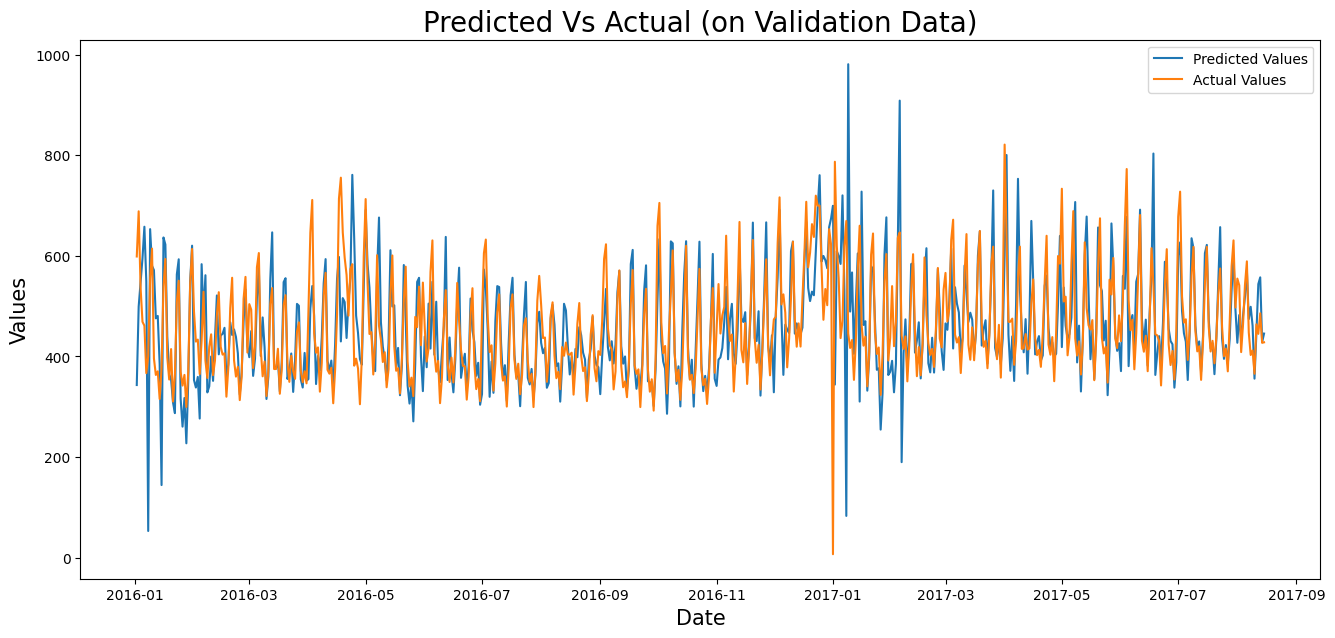

In [59]:
pred_data=pred
def result_plot(pred_data):
    fig,ax=plt.subplots(1, 1, figsize=(16, 7))
    ax.plot(pred_data,label='Predicted Values')
    ax.plot(valid_data,label='Actual Values')
    ax.legend()
    ax.set_xlabel('Date',fontsize=15)
    ax.set_ylabel('Values',fontsize=15)
    ax.set_title('Predicted Vs Actual (on Validation Data)',fontsize=20)
    plt.show()
    
result_plot(pred_data)

In [63]:
prediction=model_fit.predict(start=test['date'].min(),end=test['date'].max()).reset_index()
prediction.columns=['date','sales']
prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    16 non-null     datetime64[ns]
 1   sales   16 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 384.0 bytes


In [64]:
prediction

,date,sales
0,2017-08-16,445.387829
1,2017-08-17,381.711385
2,2017-08-18,475.949090
3,2017-08-19,464.293986
4,2017-08-20,497.351647
5,2017-08-21,430.753769
6,2017-08-22,438.975652
7,2017-08-23,447.153974
8,2017-08-24,375.174710
9,2017-08-25,482.798030


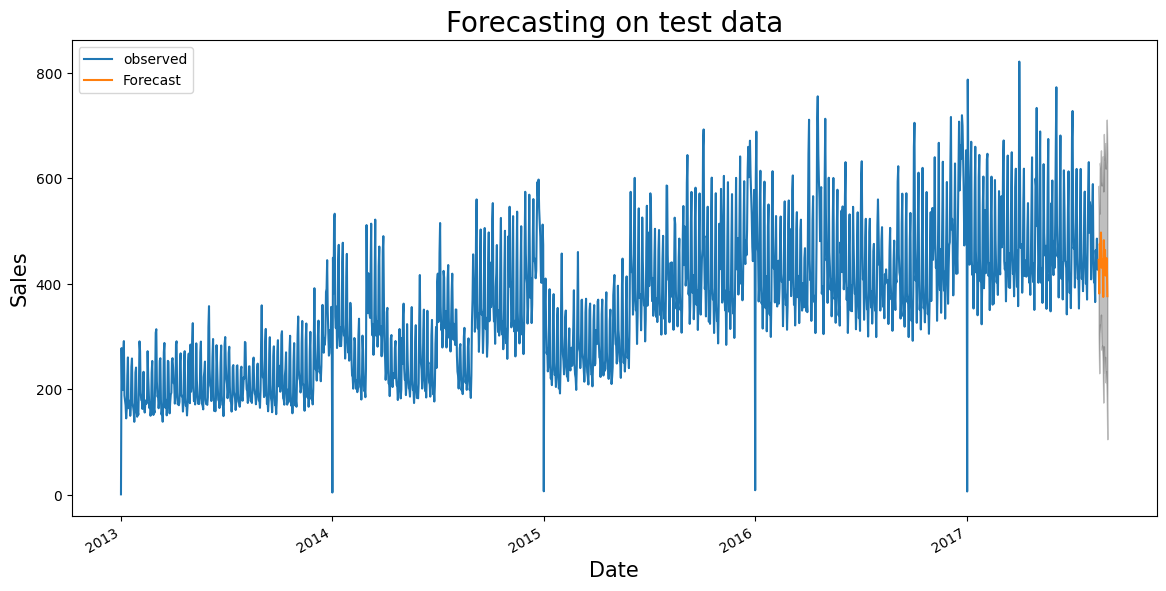

In [66]:
prediction = model_fit.get_forecast(steps=16)
y = time_series_copy['sales']#.resample('MS').mean()
pred_ci = prediction.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Sales',fontsize=15)
ax.set_title('Forecasting on test data',fontsize=20)

plt.legend()
plt.show()

In [68]:
prediction.predicted_mean

2017-08-16    445.387829
2017-08-17    381.711385
2017-08-18    475.949090
2017-08-19    464.293986
2017-08-20    497.351647
2017-08-21    430.753769
2017-08-22    438.975652
2017-08-23    447.153974
2017-08-24    375.174710
2017-08-25    482.798030
2017-08-26    433.693061
2017-08-27    464.202692
2017-08-28    415.798663
2017-08-29    437.194374
2017-08-30    448.532490
2017-08-31    376.701611
Freq: D, Name: predicted_mean, dtype: float64

In [ ]:
test["date"] = pd.to_datetime(test["date"])
submission = pd.merge(test, prediction, on="date", how = "left")

In [ ]:
submission = submission[["id", "sales"]]

In [ ]:
submission.to_csv('submission.csv',index=False)